In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

from pylightgbm.models import GBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn import metrics

Читаем наши csv файлы, в файлах есть русский текст, поэтому используем кодировку cp1251

In [2]:
test = pd.read_csv('./credit_test.csv',  encoding='cp1251', sep=';',
                   index_col='client_id')
train = pd.read_csv('./credit_train.csv',  encoding='cp1251', sep=';',
                    index_col='client_id')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 1 to 170746
Data columns (total 14 columns):
gender                  170746 non-null object
age                     170746 non-null int64
marital_status          170746 non-null object
job_position            170746 non-null object
credit_sum              170746 non-null object
credit_month            170746 non-null int64
tariff_id               170746 non-null float64
score_shk               170746 non-null object
education               170746 non-null object
living_region           170554 non-null object
monthly_income          170745 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(4), int64(3), object(7)
memory usage: 19.5+ MB


Поля ('credit_sum', 'score_shk') имеют тип - object. Надо преобразовать их в float.

In [4]:
def transformat_to_float(dataset, column):
    dataset[column].replace([','], ['.'], regex=True, inplace=True)
    dataset[column] = dataset[column].astype(np.float)

In [5]:
for x in ['credit_sum', 'score_shk']:
    transformat_to_float(train, x)
    transformat_to_float(test, x)

Переменную tariff_id сделаем категориальной 

In [6]:
train.tariff_id = train.tariff_id.astype(np.str)
test.tariff_id = test.tariff_id.astype(np.str)

In [7]:
train.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
client_id,,,,,,,,,,,,,,
1,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
2,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0
3,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
4,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
5,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [8]:
train.describe()

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,170746.000000,170746.000000,170746.000000,170746.000000,170745.000000,161516.000000,161516.000000,170746.000000
mean,36.497283,26095.047799,10.980749,0.469473,40138.288354,2.107308,0.046070,0.176028
std,10.546008,16234.794320,3.536698,0.124268,25044.205336,1.777128,0.211548,0.380845
min,18.000000,2736.000000,3.000000,0.000000,5000.000000,0.000000,0.000000,0.000000
25%,28.000000,14908.000000,10.000000,0.379495,25000.000000,1.000000,0.000000,0.000000
50%,34.000000,21229.000000,10.000000,0.461599,35000.000000,2.000000,0.000000,0.000000
75%,43.000000,32068.000000,12.000000,0.552419,50000.000000,3.000000,0.000000,0.000000
max,71.000000,200000.000000,36.000000,1.128291,950000.000000,21.000000,3.000000,1.000000


Добавляем новые переменные

In [9]:
train['mi_cs'] = train.monthly_income*train.credit_sum
train['mi_cm'] = train.monthly_income*train.credit_month
train['mi_cc'] = train.monthly_income*train.credit_count
train['mi_occ'] = train.monthly_income*train.overdue_credit_count
train['mi_div_cc'] = train.monthly_income/train.credit_count
train['mi_div_occ'] = train.monthly_income/train.overdue_credit_count
train['mi_minus_div_cc'] = (train.monthly_income-(train.credit_sum/train.credit_month))/train.credit_count
train['mi_minus_div_occ'] = (train.monthly_income-(train.credit_sum/train.credit_month))/train.overdue_credit_count


test['mi_cs'] = test.monthly_income*test.credit_sum
test['mi_cm'] = test.monthly_income*test.credit_month
test['mi_cc'] = test.monthly_income*test.credit_count
test['mi_occ'] = test.monthly_income*test.overdue_credit_count
test['mi_div_cc'] = test.monthly_income/test.credit_count
test['mi_div_occ'] = test.monthly_income/test.overdue_credit_count
test['mi_minus_div_cc'] = (test.monthly_income-(test.credit_sum/test.credit_month))/test.credit_count
test['mi_minus_div_occ'] = (test.monthly_income-(test.credit_sum/test.credit_month))/test.overdue_credit_count

Строки, имеющие пропуски, заполним нулями

In [10]:
train = train.fillna(0, axis=0)
train = train.replace(['inf', '-inf'],0, axis=0)

test = test.fillna(0, axis=0)
test = test.replace(['inf', '-inf'],0, axis=0)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3299: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warn('the "axis" argument is deprecated and will be removed in'


Переменная 'living_region' очень "грязная", имеет слишком много различных значений. Эти данные надо "чистить" с помощью "регулярных выражений". Пока отбросим этот столбец.

In [11]:
train.drop(['living_region'], inplace=True,axis=1)
#train.drop(['living_region', 'tariff_id'], inplace=True,axis=1)
test.drop(['living_region'], inplace=True,axis=1)
#test.drop(['living_region', 'tariff_id'], inplace=True,axis=1)

Разделим данные на категориальные и количественные

In [12]:
categorical_columns = [x for x in train.columns if train[x].dtype.name == 'object']
numerical_columns = [x for x in train.columns if train[x].dtype.name != 'object']
numerical_columns.remove('open_account_flg')
print(categorical_columns)
print(numerical_columns)

['gender', 'marital_status', 'job_position', 'tariff_id', 'education']
['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count', 'mi_cs', 'mi_cm', 'mi_cc', 'mi_occ', 'mi_div_cc', 'mi_div_occ', 'mi_minus_div_cc', 'mi_minus_div_occ']


In [13]:
train[categorical_columns].describe()

,gender,marital_status,job_position,tariff_id,education
count,170746,170746,170746,170746,170746
unique,2,5,18,32,5
top,F,MAR,SPC,1.1,SCH
freq,88697,93956,134680,69355,87539


Векторизация небинарных признаков

In [14]:
train_nonbinary = pd.get_dummies(train[categorical_columns])
test_nonbinary = pd.get_dummies(test[categorical_columns])

print(train_nonbinary.columns)

Index(['gender_F', 'gender_M', 'marital_status_CIV', 'marital_status_DIV',
       'marital_status_MAR', 'marital_status_UNM', 'marital_status_WID',
       'job_position_ATP', 'job_position_BIS', 'job_position_BIU',
       'job_position_DIR', 'job_position_HSK', 'job_position_INP',
       'job_position_INV', 'job_position_NOR', 'job_position_ONB',
       'job_position_PNA', 'job_position_PNI', 'job_position_PNS',
       'job_position_PNV', 'job_position_SPC', 'job_position_UMN',
       'job_position_WOI', 'job_position_WRK', 'job_position_WRP',
       'tariff_id_1.0', 'tariff_id_1.1', 'tariff_id_1.16', 'tariff_id_1.17',
       'tariff_id_1.18', 'tariff_id_1.19', 'tariff_id_1.2', 'tariff_id_1.21',
       'tariff_id_1.22', 'tariff_id_1.23', 'tariff_id_1.24', 'tariff_id_1.25',
       'tariff_id_1.26', 'tariff_id_1.27', 'tariff_id_1.28', 'tariff_id_1.29',
       'tariff_id_1.3', 'tariff_id_1.32', 'tariff_id_1.4', 'tariff_id_1.41',
       'tariff_id_1.43', 'tariff_id_1.44', 'tariff_id_1.48',

Нормализация количественных признаков

In [15]:
train_numerical = train[numerical_columns]
train_numerical = (train_numerical - train_numerical.mean()) / train_numerical.std()
train_numerical.describe()

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,mi_cs,mi_cm,mi_cc,mi_occ,mi_div_cc,mi_div_occ,mi_minus_div_cc,mi_minus_div_occ
count,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05,1.707460e+05
mean,1.930318e-16,-2.145152e-14,-9.143650e-16,1.480246e-13,1.149732e-15,1.799221e-17,-9.432500e-17,-1.918913e-16,3.192060e-16,1.479642e-15,1.261214e-15,4.507313e-15,-7.899159e-15,1.824888e-13,3.558071e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.753961e+00,-1.438826e+00,-2.256554e+00,-3.777910e+00,-1.602681e+00,-1.111818e+00,-2.115358e-01,-7.905146e-01,-1.350236e+00,-7.192199e-01,-1.749098e-01,-9.368710e-01,-1.752102e-01,-1.458770e+00,-1.729791e-01
25%,-8.057345e-01,-6.890785e-01,-2.773065e-01,-7.240659e-01,-6.044506e-01,-5.540667e-01,-2.115358e-01,-5.184079e-01,-5.855319e-01,-5.535038e-01,-1.749098e-01,-6.595270e-01,-1.752102e-01,-6.553020e-01,-1.729791e-01
50%,-2.367988e-01,-2.997296e-01,-2.773065e-01,-6.336464e-02,-2.051584e-01,3.684675e-03,-2.115358e-01,-3.067201e-01,-2.490619e-01,-2.717863e-01,-1.749098e-01,-2.488858e-01,-1.752102e-01,-2.425694e-01,-1.729791e-01
75%,6.166046e-01,3.679106e-01,2.881928e-01,6.674774e-01,3.937798e-01,5.614360e-01,-2.115358e-01,1.424034e-01,2.709372e-01,2.336480e-01,-1.749098e-01,3.531013e-01,-1.752102e-01,3.631626e-01,-1.729791e-01
max,3.271638e+00,1.071187e+01,7.074184e+00,5.301590e+00,3.633007e+01,1.060096e+01,1.435057e+01,9.254232e+01,5.370849e+01,5.893859e+01,6.319445e+01,3.518235e+01,6.406978e+01,3.670908e+01,6.634403e+01


In [16]:
test_numerical = test[numerical_columns]
test_numerical = (test_numerical - test_numerical.mean()) / test_numerical.std()
test_numerical.describe()

,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,mi_cs,mi_cm,mi_cc,mi_occ,mi_div_cc,mi_div_occ,mi_minus_div_cc,mi_minus_div_occ
count,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04,9.194000e+04
mean,-4.581451e-18,-5.731256e-15,2.182698e-15,5.066961e-14,2.517916e-16,8.660851e-16,4.410661e-16,1.332940e-16,1.830842e-16,-2.109472e-16,-1.466934e-16,3.166203e-15,3.677122e-16,6.888531e-14,1.372315e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.756151e+00,-1.421500e+00,-2.247284e+00,-3.765734e+00,-1.625920e+00,-1.119931e+00,-2.114300e-01,-8.340031e-01,-1.360348e+00,-7.452754e-01,-1.781560e-01,-9.404322e-01,-1.784411e-01,-1.022938e+00,-1.765276e-01
25%,-8.048814e-01,-6.903420e-01,-2.763121e-01,-7.234353e-01,-6.118274e-01,-5.600142e-01,-2.114300e-01,-5.461905e-01,-5.887274e-01,-5.735179e-01,-1.781560e-01,-6.459396e-01,-1.784411e-01,-6.420324e-01,-1.765276e-01
50%,-2.341195e-01,-3.036195e-01,-2.763121e-01,-6.509083e-02,-2.061903e-01,-9.744038e-05,-2.114300e-01,-3.238141e-01,-2.492144e-01,-2.815301e-01,-1.781560e-01,-2.446935e-01,-1.784411e-01,-2.377966e-01,-1.765276e-01
75%,6.220232e-01,3.649149e-01,2.868226e-01,6.641195e-01,4.022654e-01,5.598193e-01,-2.114300e-01,1.553844e-01,2.693147e-01,2.423303e-01,-1.781560e-01,3.479727e-01,-1.784411e-01,3.612826e-01,-1.765276e-01
max,3.285578e+00,1.071799e+01,7.044439e+00,6.312392e+00,2.676868e+01,1.119824e+01,1.436408e+01,4.140155e+01,3.567744e+01,2.931229e+01,3.616194e+01,3.384650e+01,3.664756e+01,3.538403e+01,3.831255e+01


Соединяем все в одну таблицу

In [17]:
data_test = pd.concat((test_numerical, test_nonbinary), axis=1)
data_test = pd.DataFrame(data_test, dtype=float)
print(data_test.shape)
print(data_test.columns)

(91940, 75)
Index(['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income',
       'credit_count', 'overdue_credit_count', 'mi_cs', 'mi_cm', 'mi_cc',
       'mi_occ', 'mi_div_cc', 'mi_div_occ', 'mi_minus_div_cc',
       'mi_minus_div_occ', 'gender_F', 'gender_M', 'marital_status_CIV',
       'marital_status_DIV', 'marital_status_MAR', 'marital_status_UNM',
       'marital_status_WID', 'job_position_ATP', 'job_position_BIS',
       'job_position_BIU', 'job_position_DIR', 'job_position_HSK',
       'job_position_INP', 'job_position_INV', 'job_position_NOR',
       'job_position_ONB', 'job_position_PNA', 'job_position_PNI',
       'job_position_PNS', 'job_position_PNV', 'job_position_SPC',
       'job_position_UMN', 'job_position_WOI', 'job_position_WRK',
       'job_position_WRP', 'tariff_id_1.0', 'tariff_id_1.1', 'tariff_id_1.16',
       'tariff_id_1.17', 'tariff_id_1.18', 'tariff_id_1.19', 'tariff_id_1.2',
       'tariff_id_1.21', 'tariff_id_1.22', 'tariff_id_1.23', 'tariff_

In [18]:
data_train = pd.concat((train_numerical, train_nonbinary), axis=1)
data_train = pd.DataFrame(data_train, dtype=float)
print(data_train.shape)
print(data_train.columns)

(170746, 77)
Index(['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income',
       'credit_count', 'overdue_credit_count', 'mi_cs', 'mi_cm', 'mi_cc',
       'mi_occ', 'mi_div_cc', 'mi_div_occ', 'mi_minus_div_cc',
       'mi_minus_div_occ', 'gender_F', 'gender_M', 'marital_status_CIV',
       'marital_status_DIV', 'marital_status_MAR', 'marital_status_UNM',
       'marital_status_WID', 'job_position_ATP', 'job_position_BIS',
       'job_position_BIU', 'job_position_DIR', 'job_position_HSK',
       'job_position_INP', 'job_position_INV', 'job_position_NOR',
       'job_position_ONB', 'job_position_PNA', 'job_position_PNI',
       'job_position_PNS', 'job_position_PNV', 'job_position_SPC',
       'job_position_UMN', 'job_position_WOI', 'job_position_WRK',
       'job_position_WRP', 'tariff_id_1.0', 'tariff_id_1.1', 'tariff_id_1.16',
       'tariff_id_1.17', 'tariff_id_1.18', 'tariff_id_1.19', 'tariff_id_1.2',
       'tariff_id_1.21', 'tariff_id_1.22', 'tariff_id_1.23', 'tariff

Посмотрим какие 10 наиболее важных признаков выделят LightGBM и XGBoost

In [19]:
# full path to lightgbm executable (on Windows include .exe)
path_to_exec = '/lightgbm.exe'

In [20]:
clf_xgb = XGBClassifier(max_depth=3, n_estimators=1000)
clf_gbm = GBMClassifier(exec_path=path_to_exec, num_iterations=1000, min_data_in_leaf=1, num_leaves=10,
                   metric='binary_error', learning_rate=0.1, early_stopping_round=10, verbose=False)


clf_xgb.fit(data_train, train.open_account_flg)
clf_gbm.fit(data_train, train.open_account_flg)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [21]:
print("xgboost: feature importance")
dic_fi = clf_xgb.booster().get_fscore()
print(dic_fi)

print("lightgbm: feature importance")
gbm_fi = clf_gbm.feature_importance(data_train.columns)
print(gbm_fi)

xgboost: feature importance
{'credit_count': 116, 'tariff_id_1.6': 72, 'mi_minus_div_occ': 128, 'marital_status_CIV': 17, 'marital_status_MAR': 41, 'tariff_id_1.7': 25, 'mi_cc': 265, 'education_UGR': 47, 'job_position_UMN': 20, 'education_ACD': 6, 'tariff_id_1.2': 13, 'job_position_NOR': 27, 'tariff_id_1.41': 11, 'job_position_WRK': 21, 'tariff_id_1.17': 11, 'tariff_id_1.52': 1, 'score_shk': 899, 'tariff_id_1.3': 46, 'tariff_id_1.91': 34, 'mi_cm': 334, 'tariff_id_1.16': 37, 'monthly_income': 260, 'job_position_DIR': 20, 'tariff_id_1.19': 32, 'tariff_id_1.5': 57, 'mi_cs': 699, 'tariff_id_1.1': 76, 'tariff_id_1.44': 34, 'job_position_SPC': 43, 'tariff_id_1.9': 37, 'tariff_id_1.24': 9, 'credit_sum': 954, 'tariff_id_1.32': 109, 'job_position_INP': 8, 'job_position_BIU': 16, 'tariff_id_1.4': 63, 'education_SCH': 68, 'mi_occ': 35, 'job_position_PNV': 5, 'education_PGR': 5, 'tariff_id_1.0': 33, 'tariff_id_1.22': 16, 'marital_status_DIV': 11, 'credit_month': 317, 'tariff_id_1.94': 7, 'marital_

In [22]:
dic_fi = pd.Series(dic_fi)
gbm_fi = pd.Series(gbm_fi)

In [23]:
dic_fi = dic_fi.sort_values(ascending=False)[:10]
gbm_fi = gbm_fi.sort_values(ascending=False)[:10]

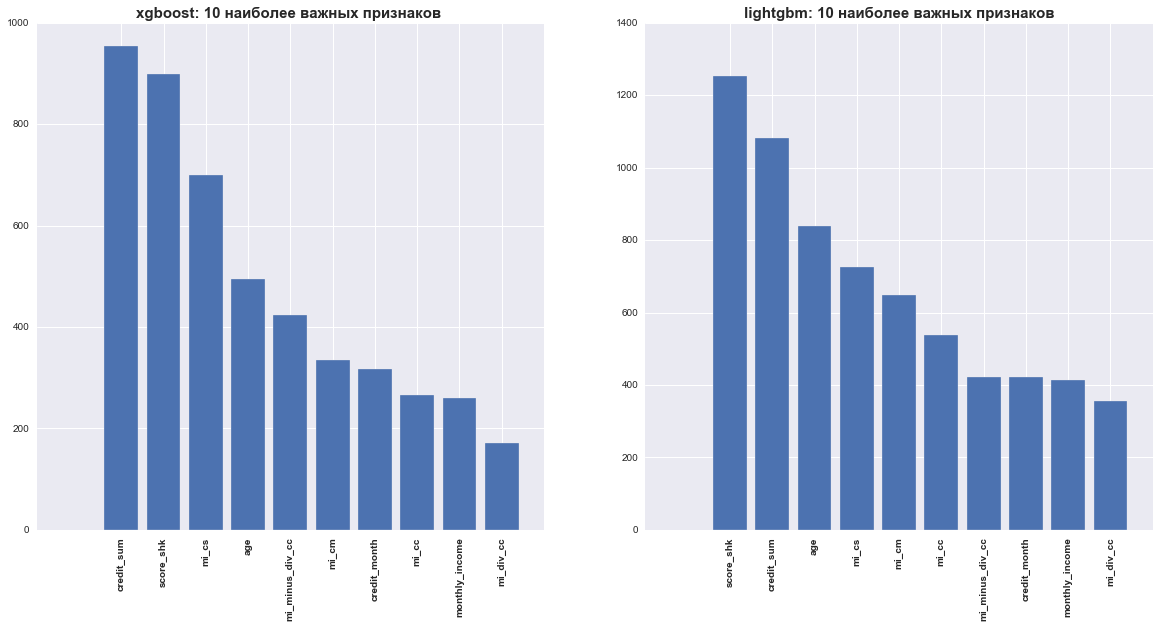

In [24]:
fig = plt.figure(figsize = (20, 20))

plt.subplot(2, 2, 1)
plt.bar(np.arange(len(dic_fi)), dic_fi.values, align='center')
plt.xticks(np.arange(len(dic_fi)), dic_fi.index, fontweight='bold', rotation='vertical')
plt.title('xgboost: 10 наиболее важных признаков ', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 2)
plt.bar(np.arange(len(gbm_fi)), gbm_fi.values, align='center')
plt.xticks(np.arange(len(gbm_fi)), gbm_fi.index, fontweight='bold', rotation='vertical')
plt.title('lightgbm: 10 наиболее важных признаков', fontsize=15, fontweight='bold')

Для предсказания воспользуемся библиотекой LightGBM.
Для начала оценим нашу модель по метрикам. Обучать модель будет на 60% данных. Для валидации используем 40% данных.

In [25]:
tr = np.array(data_train)[:len(data_train)*0.6]
te = np.array(data_train)[len(data_train)*0.6:]
lgb_model = GBMClassifier(exec_path=path_to_exec, num_iterations=10000,
                          min_data_in_leaf=1, bagging_fraction=0.5, 
                          num_leaves=10, metric='binary_error',
                          learning_rate=0.04, early_stopping_round=10,
                          verbose=False)
lgb_model.fit(np.array(tr), np.array(train.open_account_flg)[:len(train)*0.6].ravel())

predictions = lgb_model.predict(np.array(te))
actuals = np.array(train.open_account_flg)[len(train)*0.6:]

print('accuracy_score: ',metrics.accuracy_score(actuals, predictions))
print('roc_auc: ', metrics.roc_auc_score(actuals, predictions))
print('confusion_matrix: \n', metrics.confusion_matrix(actuals, predictions))
print('classification_report: \n', metrics.classification_report(actuals, predictions))

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable
accuracy_score:  0.826102871199
roc_auc:  0.554264543256
confusion_matrix: 
 [[54797  1537]
 [10340  1625]]
classification_report: 
              precision    recall  f1-score   support

          0       0.84      0.97      0.90     56334
          1       0.51      0.14      0.21     11965

avg / total       0.78      0.83      0.78     68299



C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


И непосредственно обучим модель на всех данных и сделаем предсказание

In [26]:
clf_gbm = GBMClassifier(exec_path=path_to_exec, num_iterations=10000,
                        min_data_in_leaf=1, bagging_fraction=0.5,
                        num_leaves=10,  metric='binary_error', 
                        learning_rate=0.04, early_stopping_round=10, 
                        verbose=False)

clf_gbm.fit(data_train, train.open_account_flg)

y_pred = clf_gbm.predict(data_test)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [27]:
pd.DataFrame(y_pred).to_csv('LigthGBM.csv')